### Import Dataset and Organize the Dataframe

In [1]:
# Let's import the necessary libraries
import pandas as pd

# Read in the dataset 
df = pd.read_csv('wgm_full_wave2_public_file_final_csv.csv',na_values=" ", keep_default_na=False,low_memory=False)

# Organizing the dataset:

# DEMOGRAPHIC INFORMATION
# Copy the original dataframe and select the columns associated with demograph information. 
#  These demographic factors are categorical variables; convert the datatype to 'categorical'
demographicInfo = df.copy()[['Global11Regions','Gender', 'Age','age_var3',
                             'Education','Household_Income','wbi',
                             'Subjective_Income','EMP_2010']].astype('category')

# First we add a new level/category of '99.0' to the feature:
demographicInfo['Household_Income'] = demographicInfo['Household_Income'].cat.add_categories(99.0)
demographicInfo['EMP_2010'] = demographicInfo['EMP_2010'].cat.add_categories(99.0)

# Impute the NaN values with '99.0' ('Don't Know/Refused')
demographicInfo['Household_Income'].fillna(99.0, inplace=True)
demographicInfo['EMP_2010'].fillna(99.0, inplace=True)


# QUESTIONNAIRE DATA
# Perception of science:
sciPercep = df.copy().iloc[:,6:28].astype('category')
sciPercep['W3'] = sciPercep['W3'].cat.add_categories(99.0) # Add a new level to 'W3'
sciPercep['W3'].fillna(99.0, inplace=True) # Impute the NaN values with the new level

# Impute the NaN entries with the values stated above
sciPercep['W4'].fillna(99.0, inplace=True)
sciPercep['W5B'].fillna(99.0, inplace=True)
sciPercep['W5D'].fillna(99.0, inplace=True)
sciPercep['W7C'].fillna(99.0, inplace=True)


# Perceptions about Climate Change
climateChange = df.copy().iloc[:,28:31].astype('category')
# Impute the NaN entries with the values stated above
climateChange['W14'].fillna(99.0, inplace=True)
climateChange['W15'].fillna(99.0, inplace=True)


# Perceptions of science with respect to COVID-19 pandemic
covidPercep = df.copy().iloc[:,31:38].astype('category')
# Impute the NaN entries with the values stated above
covidPercep['W15_1A'].fillna(99.0, inplace=True)
covidPercep['W15_1B'].fillna(99.0, inplace=True)
covidPercep['W15_1C'].fillna(99.0, inplace=True)
covidPercep['W15_1D'].fillna(99.0, inplace=True)
covidPercep['W15_1E'].fillna(99.0, inplace=True)
covidPercep['W15_2A'].fillna(99.0, inplace=True)
covidPercep['W15_2B'].fillna(99.0, inplace=True)


# Perceptions about physical and mental health:
sciHealth = df.copy().iloc[:,38:67].astype('category')
# Impute the NaN entries with the values stated above for MH3A to MH5 + MH7A
sciHealth['MH3A'].fillna(99.0, inplace=True)
sciHealth['MH3B'].fillna(99.0, inplace=True)
sciHealth['MH3C'].fillna(99.0, inplace=True)
sciHealth['MH3D'].fillna(99.0, inplace=True)
sciHealth['MH4A'].fillna(99.0, inplace=True)
sciHealth['MH4B'].fillna(99.0, inplace=True)
sciHealth['MH5'].fillna(99.0, inplace=True)
sciHealth['MH7A'].fillna(99.0, inplace=True)
# Impute the NaN entries with the values stated above for MH1 and MH6
sciHealth['MH1'].fillna(99, inplace=True)
sciHealth['MH6'].fillna(99, inplace=True)


# Social Media Usage
socialMedia = df.copy().iloc[:,67:70].astype('category')
# Impute the NaN values
socialMedia['W28'].fillna(99.0, inplace=True)
socialMedia['W29'].fillna(99.0, inplace=True)


# Religion
religion = df.copy()['W30'].astype('category')

# Impute missing values
religion.fillna(99.0, inplace=True)

Generating the final dataset used for Classification

In [2]:
questionDataset = pd.concat([sciPercep, climateChange, covidPercep,sciHealth.iloc[:,0:10], socialMedia, religion.to_frame()],axis=1)
# Remove 'Age' and keep 'age_var3'
demographicInfo = demographicInfo.drop('Age',axis=1)

dataset = pd.concat([demographicInfo, questionDataset],axis=1)
dataset.shape # 119 088 entries and 54 columns/features

(119088, 54)

In [3]:
dataset = dataset[(dataset['MH7A'] == 1.0) | (dataset['MH7A'] == 2.0)]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116810 entries, 0 to 119087
Data columns (total 54 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Global11Regions    116810 non-null  category
 1   Gender             116810 non-null  category
 2   age_var3           116810 non-null  category
 3   Education          116810 non-null  category
 4   Household_Income   116810 non-null  category
 5   wbi                116810 non-null  category
 6   Subjective_Income  116810 non-null  category
 7   EMP_2010           116810 non-null  category
 8   W1                 116810 non-null  category
 9   W2                 116810 non-null  category
 10  W3                 116810 non-null  category
 11  W4                 116810 non-null  category
 12  W5A                116810 non-null  category
 13  W5B                116810 non-null  category
 14  W5C                116810 non-null  category
 15  W5D                116810 non-null

### Classification

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Splitting the dataset into features and target/label:

In [5]:
y = dataset['MH7A'] # The label: MH7A 
y.shape # 119 088 entries

(116810,)

In [6]:
X = dataset.drop(columns='MH7A') # The independent variables/features used for classification
X.shape # 119 088 entries and 54 columns/features

(116810, 53)

Split the dataset into training/testing sets using a 70/30 split:

In [7]:
# 70% training and 30% test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

In [8]:
X_train.shape

(81767, 53)

In [9]:
X_test.shape

(35043, 53)

### Feature Selection

Based on the chi-squared test scores shown, let's set a threshold of 2000. Any features that have a score greater than 2000 will be included as a feature in future models.

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# # Using the Chi-Squared test to identify features that are NOT independent of the target variable/label
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# what are scores for the features
#for i in range(len(fs.scores_)):
# print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
#plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
#plt.title('Feature Selection: Chi-Squared Test')
#plt.ylabel('Chi-Squared Statistic')
#plt.xlabel('Feature')
#plt.show()

In [11]:
selector = SelectKBest(score_func=chi2, k=17)
selector.fit(X_train, y_train)
# Get columns to keep and create new dataframe with those only
cols_idxs = selector.get_support(indices=True)
X_fs = X_train.iloc[:,cols_idxs]

In [12]:
X_fs

,W5B,W11A,MH2B,W15_1A,W15_1B,W15_1C,W15_1D,W15_1E,W15_2A,W15_2B,MH3B,MH3D,MH5,MH6,W28,W29,W30
43560,2.0,1,2,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,99,99.0,99.0,1.0
62908,4.0,1,99,4.0,3.0,1.0,1.0,99.0,3.0,1.0,3.0,99.0,1.0,2,3.0,3.0,3.0
34789,2.0,1,2,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2,99.0,99.0,2.0
55266,1.0,2,1,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0
75584,99.0,1,3,1.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,2,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50736,1.0,3,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2,3.0,3.0,4.0
99189,99.0,1,4,99.0,1.0,2.0,2.0,99.0,1.0,1.0,2.0,3.0,1.0,1,1.0,2.0,1.0
5214,3.0,1,1,3.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1,3.0,2.0,2.0
78640,3.0,1,3,2.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,3.0,2,2.0,3.0,1.0


In [13]:
# Let's add the demographic features into X_fs:
X_train_fs = pd.concat([X_train.iloc[:,1], X_fs],axis=1)
X_train_fs

,Gender,W5B,W11A,MH2B,W15_1A,W15_1B,W15_1C,W15_1D,W15_1E,W15_2A,W15_2B,MH3B,MH3D,MH5,MH6,W28,W29,W30
43560,2,2.0,1,2,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,99,99.0,99.0,1.0
62908,1,4.0,1,99,4.0,3.0,1.0,1.0,99.0,3.0,1.0,3.0,99.0,1.0,2,3.0,3.0,3.0
34789,2,2.0,1,2,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2,99.0,99.0,2.0
55266,2,1.0,2,1,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0
75584,2,99.0,1,3,1.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,2,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50736,2,1.0,3,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2,3.0,3.0,4.0
99189,1,99.0,1,4,99.0,1.0,2.0,2.0,99.0,1.0,1.0,2.0,3.0,1.0,1,1.0,2.0,1.0
5214,2,3.0,1,1,3.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1,3.0,2.0,2.0
78640,2,3.0,1,3,2.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,3.0,2,2.0,3.0,1.0


Let's define some scoring metrics

In [14]:
# Define custom scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

#### Baseline Classifier using Decision Tree
- gini impurity measure
- using all 53 features

# Create Decision Tree Classifier object
clfDT = DecisionTreeClassifier(random_state=1)

# Fit the model
clfDT.fit(X_train, y_train)

# Predicting labels for the Test Set
y_pred = clfDT.predict(X_test)

print(confusion_matrix(y_test, y_pred))

# TN, FP
# FN, TP
## y_pred: Predicted labels
## y_test: True Labels

cm = confusion_matrix(y_test, y_pred, labels=clfDT.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clfDT.classes_)
disp.plot()
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("MCC:", matthews_corrcoef(y_test, y_pred))

# Create Decision Tree Classifier object
clfDT = DecisionTreeClassifier(random_state=1)

# Perform 10-fold cross-validation with custom scoring metrics
cv_results = cross_validate(clfDT, X_train, y_train, cv=10, scoring=scoring)

# Print the results
print(cv_results)

# 10-fold cross-validation
print("Baseline Classifier F1-score\nMean: {mean}\nStd: {std}".format(mean=np.mean(cv_results['test_f1_score']),
                                                                      std=np.std(cv_results['test_f1_score'])))

#### Classification using smaller Feature Set

First let's update X_test with the new features:

In [15]:
X_train_fs.info() # 18 features now being used

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81767 entries, 43560 to 99685
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Gender  81767 non-null  category
 1   W5B     81767 non-null  category
 2   W11A    81767 non-null  category
 3   MH2B    81767 non-null  category
 4   W15_1A  81767 non-null  category
 5   W15_1B  81767 non-null  category
 6   W15_1C  81767 non-null  category
 7   W15_1D  81767 non-null  category
 8   W15_1E  81767 non-null  category
 9   W15_2A  81767 non-null  category
 10  W15_2B  81767 non-null  category
 11  MH3B    81767 non-null  category
 12  MH3D    81767 non-null  category
 13  MH5     81767 non-null  category
 14  MH6     81767 non-null  category
 15  W28     81767 non-null  category
 16  W29     81767 non-null  category
 17  W30     81767 non-null  category
dtypes: category(18)
memory usage: 2.0 MB


In [16]:
# Get columns to keep and create new dataframe with those only
cols_idxs = selector.get_support(indices=True)
X_test_fs = X_test.iloc[:,cols_idxs]

# The testing set to be used
X_test_fs = pd.concat([X_test.iloc[:,1],X_test_fs],axis=1)

In [17]:
X_test_fs.shape

(35043, 18)

#### 10-fold Cross-validation

# Create Decision Tree Classifier object
clfDT_fs = DecisionTreeClassifier(random_state=1)

# Perform 10-fold cross-validation with custom scoring metrics
cv_results = cross_validate(clfDT_fs, X_train_fs, y_train, cv=10, scoring=scoring)

# Print the results
print(cv_results)

# 10-fold cross-validation
print("Baseline Classifier F1-score\nMean: {mean}\nStd: {std}".format(mean=np.mean(cv_results['test_f1_score']),
                                                                      std=np.std(cv_results['test_f1_score'])))

#### Using the Testing Set:

# Create Decision Tree Classifier object
clfDT_fs = DecisionTreeClassifier(random_state=1)

# Fit the model
clfDT_fs.fit(X_train_fs, y_train)

# Predicting labels for the Test Set
y_pred_fs = clfDT_fs.predict(X_test_fs)

print(confusion_matrix(y_test, y_pred_fs))

# TN, FP
# FN, TP
## y_pred: Predicted labels
## y_test: True Labels

cm = confusion_matrix(y_test, y_pred_fs, labels=clfDT_fs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clfDT_fs.classes_)
disp.plot()
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred_fs))
print("Precision:", precision_score(y_test, y_pred_fs))
print("Recall:", recall_score(y_test, y_pred_fs))
print("F1 Score:", f1_score(y_test, y_pred_fs))
print("MCC:", matthews_corrcoef(y_test, y_pred))

### Balancing the dataset
Let's apply an imbalance treatment by undersampling the majority class (i.e. 'No' to MH7A)

In [18]:
from imblearn.under_sampling import RandomUnderSampler

Text(0, 0.5, 'Counts')

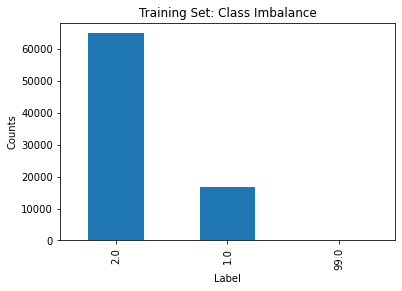

In [19]:
y_train.value_counts().plot(kind='bar', title='Training Set: Class Imbalance');
plt.xlabel('Label')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

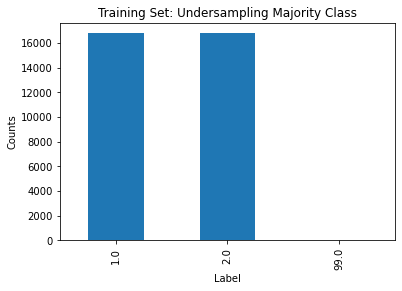

In [20]:
rus = RandomUnderSampler(random_state=1)
X_rus, y_rus = rus.fit_resample(X_train_fs, y_train)
y_rus.value_counts().plot(kind='bar', title='Training Set: Undersampling Majority Class');
plt.xlabel('Label')
plt.ylabel('Counts')

In [21]:
print('Size of training Set with class imbalance:', X_train_fs.shape)
print('Size of training Set with undersampling:', X_rus.shape)

Size of training Set with class imbalance: (81767, 18)
Size of training Set with undersampling: (33582, 18)


#### 10 fold cross-validation

Decision Tree

In [22]:
clfDT_rus = DecisionTreeClassifier()

# Perform 10-fold cross-validation with custom scoring metrics
cv_resultsDT = cross_validate(clfDT_rus, X_rus, y_rus, cv=10, scoring=scoring)

# Print the results
print(cv_resultsDT)

{'fit_time': array([0.15104675, 0.1390152 , 0.13903832, 0.14103794, 0.14104342,
       0.1800344 , 0.18404102, 0.14805222, 0.14104271, 0.13302922]), 'score_time': array([0.00899529, 0.00900245, 0.008008  , 0.00799584, 0.00899649,
       0.01200414, 0.0100019 , 0.00898504, 0.00898933, 0.00800276]), 'test_accuracy': array([0.58916344, 0.58023221, 0.57593806, 0.59023228, 0.57683145,
       0.60393091, 0.59410363, 0.5970816 , 0.57772484, 0.58308517]), 'test_precision': array([0.59259259, 0.57672561, 0.57639305, 0.59066427, 0.57606132,
       0.60282852, 0.59305065, 0.59487776, 0.57894737, 0.58429003]), 'test_recall': array([0.57142857, 0.60214413, 0.5729601 , 0.58784991, 0.58189398,
       0.60929124, 0.59976176, 0.60869565, 0.56998213, 0.57593806]), 'test_f1_score': array([0.58181818, 0.58916084, 0.57467145, 0.58925373, 0.57896296,
       0.60604265, 0.59638733, 0.60170739, 0.57442977, 0.58008398])}


In [23]:
# 10-fold cross-validation
print("Baseline Classifier F1-score\nMean: {mean}\nStd: {std}".format(mean=np.mean(cv_resultsDT['test_f1_score']),
                                                                      std=np.std(cv_resultsDT['test_f1_score'])))

Baseline Classifier F1-score
Mean: 0.5872518284966569
Std: 0.010608706726213005


In [24]:
# Fit Time
print("Baseline Classifier Average Fit Time: {fit}".format(fit=np.mean(cv_resultsDT['fit_time'])))

Baseline Classifier Average Fit Time: 0.14973812103271483


In [126]:
DT_metrics = pd.concat([pd.DataFrame(np.tile("DT",10).astype('str')),pd.DataFrame(cv_resultsDT)],axis=1)
DT_metrics.rename(columns={0:"Classifier"})

,Classifier,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,DT,0.151047,0.008995,0.589163,0.592593,0.571429,0.581818
1,DT,0.139015,0.009002,0.580232,0.576726,0.602144,0.589161
2,DT,0.139038,0.008008,0.575938,0.576393,0.572960,0.574671
3,DT,0.141038,0.007996,0.590232,0.590664,0.587850,0.589254
4,DT,0.141043,0.008996,0.576831,0.576061,0.581894,0.578963
5,DT,0.180034,0.012004,0.603931,0.602829,0.609291,0.606043
6,DT,0.184041,0.010002,0.594104,0.593051,0.599762,0.596387
7,DT,0.148052,0.008985,0.597082,0.594878,0.608696,0.601707
8,DT,0.141043,0.008989,0.577725,0.578947,0.569982,0.574430
9,DT,0.133029,0.008003,0.583085,0.584290,0.575938,0.580084


Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
# Create Random Forest Classifier object
clf_RF = RandomForestClassifier()

# Perform 10-fold cross-validation with custom scoring metrics
cv_resultsRF = cross_validate(clf_RF, X_rus, y_rus, cv=10, scoring=scoring)

# Print the results
print(cv_resultsRF)

{'fit_time': array([3.09769082, 3.140697  , 3.03168511, 3.0373528 , 2.98766351,
       3.12969375, 3.27574253, 3.16771984, 3.24573803, 3.2598381 ]), 'score_time': array([0.09403849, 0.10403967, 0.09003091, 0.09201002, 0.08901954,
       0.10303545, 0.09802675, 0.1110096 , 0.08703113, 0.10201192]), 'test_accuracy': array([0.70318547, 0.68949092, 0.69982132, 0.68790947, 0.69446099,
       0.71232877, 0.70696843, 0.71590232, 0.69267421, 0.69624777]), 'test_precision': array([0.70219065, 0.68424102, 0.69700528, 0.68504399, 0.69037901,
       0.70476738, 0.70405167, 0.71615981, 0.69267421, 0.68839337]), 'test_recall': array([0.70595238, 0.70339488, 0.70696843, 0.69565217, 0.70518166,
       0.73079214, 0.71411554, 0.71530673, 0.69267421, 0.71709351]), 'test_f1_score': array([0.70406649, 0.69368576, 0.70195151, 0.69030733, 0.69770183,
       0.71754386, 0.7090479 , 0.71573302, 0.69267421, 0.70245041])}


In [28]:
# 10-fold cross-validation; Balanced Dataset
print("Random Forest F1-score\nMean: {mean}\nStd: {std}".format(mean=np.mean(cv_resultsRF['test_f1_score']),
                                                                      std=np.std(cv_resultsRF['test_f1_score'])))

Random Forest F1-score
Mean: 0.7025162303190283
Std: 0.008904946367621246


In [29]:
# Fit Time
print("Random Forest Average Fit Time: {fit}".format(fit=np.mean(cv_resultsRF['fit_time'])))

Random Forest Average Fit Time: 3.13738214969635


In [139]:
RF_metrics = pd.concat([pd.DataFrame(np.tile("RF",10)),pd.DataFrame(cv_resultsRF)],axis=1)
RF_metrics.rename(columns={0:"Classifier"})

,Classifier,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,RF,3.097691,0.094038,0.703185,0.702191,0.705952,0.704066
1,RF,3.140697,0.104040,0.689491,0.684241,0.703395,0.693686
2,RF,3.031685,0.090031,0.699821,0.697005,0.706968,0.701952
3,RF,3.037353,0.092010,0.687909,0.685044,0.695652,0.690307
4,RF,2.987664,0.089020,0.694461,0.690379,0.705182,0.697702
5,RF,3.129694,0.103035,0.712329,0.704767,0.730792,0.717544
6,RF,3.275743,0.098027,0.706968,0.704052,0.714116,0.709048
7,RF,3.167720,0.111010,0.715902,0.716160,0.715307,0.715733
8,RF,3.245738,0.087031,0.692674,0.692674,0.692674,0.692674
9,RF,3.259838,0.102012,0.696248,0.688393,0.717094,0.702450


Naive Bayes

In [30]:
from sklearn.naive_bayes import CategoricalNB

In [31]:
# create model object
clf_NB = CategoricalNB()

# Perform 10-fold cross-validation with custom scoring metrics
cv_resultsNB = cross_validate(clf_NB, X_rus, y_rus, cv=10, scoring=scoring)

# Print the results
print(cv_resultsNB)

{'fit_time': array([0.02201104, 0.02100515, 0.01999307, 0.02099943, 0.02101111,
       0.02100372, 0.02300978, 0.02101707, 0.02101159, 0.02102208]), 'score_time': array([0.00900745, 0.00798988, 0.00801301, 0.00900173, 0.00799298,
       0.00899959, 0.00899029, 0.00898933, 0.00899625, 0.00799012]), 'test_accuracy': array([0.68442989, 0.67639178, 0.6855271 , 0.67153067, 0.68225134,
       0.69833234, 0.68820727, 0.70041691, 0.68433591, 0.68374032]), 'test_precision': array([0.67633675, 0.66742081, 0.67708926, 0.66475973, 0.67346939,
       0.6875    , 0.68140069, 0.69462117, 0.67859204, 0.67091413]), 'test_recall': array([0.7077381 , 0.70279929, 0.7093508 , 0.69207862, 0.70756403,
       0.72721858, 0.70696843, 0.71530673, 0.70041691, 0.72126266]), 'test_f1_score': array([0.69168121, 0.68465332, 0.69284468, 0.67814415, 0.69009585,
       0.70680174, 0.69394914, 0.70481221, 0.68933177, 0.69517796])}


In [32]:
# 10-fold cross-validation; Balanced Dataset
print("Naive Bayes F1-score\nMean: {mean}\nStd: {std}".format(mean=np.mean(cv_resultsNB['test_f1_score']),
                                                                      std=np.std(cv_resultsNB['test_f1_score'])))

Naive Bayes F1-score
Mean: 0.6927492012380049
Std: 0.008056352757742538


In [33]:
# Fit Time
print("Naive Bayes Average Fit Time: {fit}".format(fit=np.mean(cv_resultsNB['fit_time'])))

Naive Bayes Average Fit Time: 0.02120840549468994


In [138]:
NB_metrics = pd.concat([pd.DataFrame(np.tile("NB",10)),pd.DataFrame(cv_resultsNB)],axis=1)
NB_metrics.rename(columns={0:"Classifier"})

,Classifier,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,NB,0.022011,0.009007,0.684430,0.676337,0.707738,0.691681
1,NB,0.021005,0.007990,0.676392,0.667421,0.702799,0.684653
2,NB,0.019993,0.008013,0.685527,0.677089,0.709351,0.692845
3,NB,0.020999,0.009002,0.671531,0.664760,0.692079,0.678144
4,NB,0.021011,0.007993,0.682251,0.673469,0.707564,0.690096
5,NB,0.021004,0.009000,0.698332,0.687500,0.727219,0.706802
6,NB,0.023010,0.008990,0.688207,0.681401,0.706968,0.693949
7,NB,0.021017,0.008989,0.700417,0.694621,0.715307,0.704812
8,NB,0.021012,0.008996,0.684336,0.678592,0.700417,0.689332
9,NB,0.021022,0.007990,0.683740,0.670914,0.721263,0.695178


Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression as LR

In [36]:
# create model object
clf_LR = LR(solver='liblinear')

# Perform 10-fold cross-validation with custom scoring metrics
cv_resultsLR = cross_validate(clf_LR, X_rus, y_rus, cv=10, scoring=scoring)

# Print the results
print(cv_resultsLR)

{'fit_time': array([0.38709092, 0.40709066, 0.33206272, 0.34508419, 0.31407142,
       0.36210036, 0.34860349, 0.33408427, 0.36308932, 0.37709141]), 'score_time': array([0.00799656, 0.0080018 , 0.00700116, 0.00699472, 0.00800109,
       0.00799012, 0.00698996, 0.00799918, 0.00798845, 0.00700068]), 'test_accuracy': array([0.55135457, 0.53051503, 0.53901132, 0.54675402, 0.54288267,
       0.54258487, 0.54377606, 0.54973198, 0.52888624, 0.53782013]), 'test_precision': array([0.53919348, 0.52198276, 0.52834271, 0.53367653, 0.53141361,
       0.52963116, 0.53068894, 0.53641518, 0.52143173, 0.52731183]), 'test_recall': array([0.70833333, 0.72126266, 0.72721858, 0.74091721, 0.7254318 ,
       0.76116736, 0.75699821, 0.73257892, 0.70279929, 0.73019655]), 'test_f1_score': array([0.6122974 , 0.60565141, 0.61203008, 0.62044888, 0.61344749,
       0.62463343, 0.6239568 , 0.61933535, 0.59868087, 0.61238761])}


In [37]:
# 10-fold cross-validation; Balanced Dataset
print("Logistic Regression F1-score\nMean: {mean}\nStd: {std}".format(mean=np.mean(cv_resultsLR['test_f1_score']),
                                                                      std=np.std(cv_resultsLR['test_f1_score'])))

Logistic Regression F1-score
Mean: 0.6142869324548339
Std: 0.007716848019085994


In [38]:
# Fit Time
print("Logistic Regression Average Fit Time: {fit}".format(fit=np.mean(cv_resultsLR['fit_time'])))

Logistic Regression Average Fit Time: 0.3570368766784668


In [137]:
LR_metrics = pd.concat([pd.DataFrame(np.tile("LR",10)),pd.DataFrame(cv_resultsLR)],axis=1)
LR_metrics.rename(columns={0:"Classifier"})

,Classifier,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,LR,0.387091,0.007997,0.551355,0.539193,0.708333,0.612297
1,LR,0.407091,0.008002,0.530515,0.521983,0.721263,0.605651
2,LR,0.332063,0.007001,0.539011,0.528343,0.727219,0.612030
3,LR,0.345084,0.006995,0.546754,0.533677,0.740917,0.620449
4,LR,0.314071,0.008001,0.542883,0.531414,0.725432,0.613447
5,LR,0.362100,0.007990,0.542585,0.529631,0.761167,0.624633
6,LR,0.348603,0.006990,0.543776,0.530689,0.756998,0.623957
7,LR,0.334084,0.007999,0.549732,0.536415,0.732579,0.619335
8,LR,0.363089,0.007988,0.528886,0.521432,0.702799,0.598681
9,LR,0.377091,0.007001,0.537820,0.527312,0.730197,0.612388


## Comparing Performance Metrics

In [130]:
clf_metrics = pd.concat([DT_metrics, RF_metrics, NB_metrics, LR_metrics], axis=0)
clf_metrics.rename(columns={0:"Model"},inplace=True)

In [131]:
np.arange(0,len(clf_metrics.index))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

In [132]:
clf_metrics.set_index(np.arange(0,len(clf_metrics.index)),inplace=True)

In [133]:
clf_metrics

,Model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,DT,0.151047,0.008995,0.589163,0.592593,0.571429,0.581818
1,DT,0.139015,0.009002,0.580232,0.576726,0.602144,0.589161
2,DT,0.139038,0.008008,0.575938,0.576393,0.572960,0.574671
3,DT,0.141038,0.007996,0.590232,0.590664,0.587850,0.589254
4,DT,0.141043,0.008996,0.576831,0.576061,0.581894,0.578963
5,DT,0.180034,0.012004,0.603931,0.602829,0.609291,0.606043
6,DT,0.184041,0.010002,0.594104,0.593051,0.599762,0.596387
7,DT,0.148052,0.008985,0.597082,0.594878,0.608696,0.601707
8,DT,0.141043,0.008989,0.577725,0.578947,0.569982,0.574430
9,DT,0.133029,0.008003,0.583085,0.584290,0.575938,0.580084


In [134]:
import seaborn as sns

In [135]:
clf_metrics.columns

Index(['Model', 'fit_time', 'score_time', 'test_accuracy', 'test_precision',
       'test_recall', 'test_f1_score'],
      dtype='object')

In [136]:
clf_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Model           40 non-null     object 
 1   fit_time        40 non-null     float64
 2   score_time      40 non-null     float64
 3   test_accuracy   40 non-null     float64
 4   test_precision  40 non-null     float64
 5   test_recall     40 non-null     float64
 6   test_f1_score   40 non-null     float64
dtypes: float64(6), object(1)
memory usage: 2.5+ KB


[Text(0.5, 0, 'Model'),
 Text(0, 0.5, 'F1 Score'),
 Text(0.5, 1.0, 'Comparison of F1-Scores')]

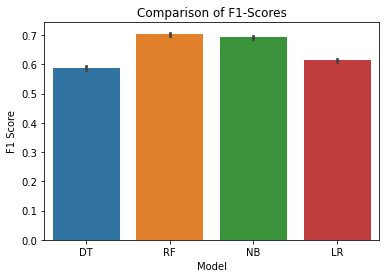

In [156]:
ax = sns.barplot(data=clf_metrics, x="Model", y="test_f1_score")
ax.set(xlabel='Model',
       ylabel='F1 Score',
       title='Comparison of F1-Scores')

[Text(0.5, 0, 'Model'),
 Text(0, 0.5, 'Time (s)'),
 Text(0.5, 1.0, 'Comparison of Model Fit Times')]

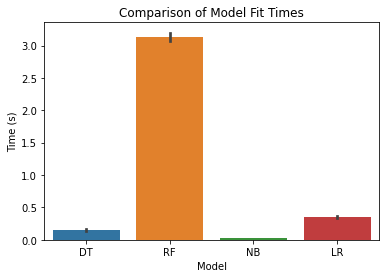

In [154]:
ax = sns.barplot(data=clf_metrics, x="Model", y="fit_time")
ax.set(xlabel='Model',
       ylabel='Time (s)',
       title='Comparison of Model Fit Times')

In [160]:
import scipy.stats as stats

# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(DT_metrics['test_f1_score'], RF_metrics['test_f1_score'], 
                                NB_metrics['test_f1_score'], LR_metrics['test_f1_score'])
print(fvalue, pvalue)

371.63713429162607 3.954883903049433e-27


In [163]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=clf_metrics['test_f1_score'],     # Data
                          groups=clf_metrics['Model'],   # Groups
                          alpha=0.05)          # Significance level

#display results
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
    DT     LR    0.027   0.0  0.0157 0.0383   True
    DT     NB   0.1055   0.0  0.0942 0.1168   True
    DT     RF   0.1153   0.0   0.104 0.1266   True
    LR     NB   0.0785   0.0  0.0672 0.0898   True
    LR     RF   0.0882   0.0  0.0769 0.0995   True
    NB     RF   0.0098  0.11 -0.0015 0.0211  False
--------------------------------------------------


In [161]:
clf_metrics

,Model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,DT,0.151047,0.008995,0.589163,0.592593,0.571429,0.581818
1,DT,0.139015,0.009002,0.580232,0.576726,0.602144,0.589161
2,DT,0.139038,0.008008,0.575938,0.576393,0.572960,0.574671
3,DT,0.141038,0.007996,0.590232,0.590664,0.587850,0.589254
4,DT,0.141043,0.008996,0.576831,0.576061,0.581894,0.578963
5,DT,0.180034,0.012004,0.603931,0.602829,0.609291,0.606043
6,DT,0.184041,0.010002,0.594104,0.593051,0.599762,0.596387
7,DT,0.148052,0.008985,0.597082,0.594878,0.608696,0.601707
8,DT,0.141043,0.008989,0.577725,0.578947,0.569982,0.574430
9,DT,0.133029,0.008003,0.583085,0.584290,0.575938,0.580084


Using the Testing Set:

In [104]:
# Create Decision Tree Classifier object
clfDT_rus = DecisionTreeClassifier(random_state=1)

# Fit the model
clfDT_rus.fit(X_rus, y_rus)

# Predicting labels for the Test Set
y_pred_rus = clfDT_rus.predict(X_test_fs)

print(confusion_matrix(y_test, y_pred_rus))

# TN, FP
# FN, TP
## y_pred: Predicted labels
## y_test: True Labels

[[ 4268  2912]
 [11361 16502]]


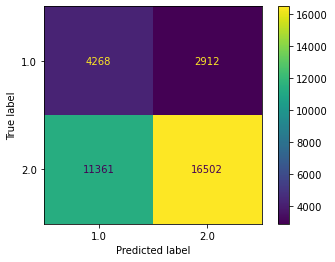

In [105]:
cm = confusion_matrix(y_test, y_pred_rus, labels=clfDT_rus.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clfDT_rus.classes_)
disp.plot()
plt.show()

In [106]:
print("Accuracy:", accuracy_score(y_test, y_pred_rus))
print("Precision:", precision_score(y_test, y_pred_rus))
print("Recall:", recall_score(y_test, y_pred_rus))
print("F1 Score:", f1_score(y_test, y_pred_rus))
print("MCC:", matthews_corrcoef(y_test, y_pred))

Accuracy: 0.5927003966555375
Precision: 0.2730820909847079
Recall: 0.5944289693593314
F1 Score: 0.37423823929150773
MCC: 0.16523814459864605


In [107]:
print(classification_report(y_test, y_pred_rus))

              precision    recall  f1-score   support

         1.0       0.27      0.59      0.37      7180
         2.0       0.85      0.59      0.70     27863

    accuracy                           0.59     35043
   macro avg       0.56      0.59      0.54     35043
weighted avg       0.73      0.59      0.63     35043



### Removing the demographic feature of gender
- Only using Behavioural/Beliefs features

In [65]:
X_rus.columns

Index(['Gender', 'W5B', 'W11A', 'MH2B', 'W15_1A', 'W15_1B', 'W15_1C', 'W15_1D',
       'W15_1E', 'W15_2A', 'W15_2B', 'MH3B', 'MH3D', 'MH5', 'MH6', 'W28',
       'W29', 'W30'],
      dtype='object')

In [66]:
X_rus.drop('Gender', axis=1, inplace=True)

In [67]:
X_rus

,W5B,W11A,MH2B,W15_1A,W15_1B,W15_1C,W15_1D,W15_1E,W15_2A,W15_2B,MH3B,MH3D,MH5,MH6,W28,W29,W30
0,2.0,1,2,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2,99.0,99.0,2.0
1,1.0,2,1,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0
2,4.0,1,4,4.0,4.0,1.0,4.0,4.0,2.0,2.0,4.0,1.0,1.0,1,5.0,1.0,1.0
3,1.0,2,3,3.0,4.0,2.0,1.0,4.0,1.0,1.0,2.0,3.0,3.0,2,3.0,3.0,1.0
4,4.0,1,2,2.0,4.0,2.0,2.0,4.0,1.0,4.0,2.0,2.0,3.0,1,3.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33577,2.0,2,3,2.0,2.0,2.0,2.0,4.0,4.0,2.0,2.0,3.0,3.0,2,1.0,3.0,1.0
33578,3.0,2,3,2.0,2.0,1.0,1.0,2.0,4.0,1.0,2.0,1.0,2.0,2,3.0,1.0,2.0
33579,4.0,1,1,4.0,1.0,1.0,1.0,4.0,4.0,1.0,1.0,1.0,2.0,1,4.0,3.0,99.0
33580,1.0,99,99,99.0,99.0,99.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,2,6.0,2.0,99.0


In [68]:
X_test_fs.drop('Gender', axis=1, inplace=True)

In [69]:
clfDT_rus = DecisionTreeClassifier()

# Perform 10-fold cross-validation with custom scoring metrics
cv_results = cross_validate(clfDT_rus, X_rus, y_rus, cv=10, scoring=scoring)

# Print the results
print(cv_results)

{'fit_time': array([0.13104153, 0.13103533, 0.13902569, 0.1290288 , 0.12803626,
       0.13201904, 0.13103533, 0.14702153, 0.13003469, 0.13403749]), 'score_time': array([0.0080018 , 0.00799608, 0.00900793, 0.00900197, 0.00899458,
       0.01001859, 0.00800157, 0.00900149, 0.00999498, 0.00999594]), 'test_accuracy': array([0.59481989, 0.583507  , 0.58368076, 0.57712924, 0.580405  ,
       0.58993448, 0.59767719, 0.58129839, 0.57683145, 0.58546754]), 'test_precision': array([0.59719683, 0.58274232, 0.58308693, 0.57843731, 0.58054893,
       0.58945498, 0.59738717, 0.57959184, 0.57789855, 0.58618619]), 'test_recall': array([0.58333333, 0.58725432, 0.58725432, 0.56879095, 0.57951161,
       0.59261465, 0.59916617, 0.59201906, 0.56998213, 0.58129839]), 'test_f1_score': array([0.59018368, 0.58498962, 0.5851632 , 0.57357357, 0.58002981,
       0.59103059, 0.59827535, 0.58573954, 0.57391304, 0.58373206])}


In [70]:
# 10-fold cross-validation
print("Baseline Classifier F1-score\nMean: {mean}\nStd: {std}".format(mean=np.mean(cv_results['test_f1_score']),
                                                                      std=np.std(cv_results['test_f1_score'])))

Baseline Classifier F1-score
Mean: 0.5846630463200368
Std: 0.007202125239739616


In [57]:
# Create Decision Tree Classifier object
clfDT_rus = DecisionTreeClassifier(random_state=1)

# Fit the model
clfDT_rus.fit(X_rus, y_rus)

# Predicting labels for the Test Set
y_pred_rus = clfDT_rus.predict(X_test_fs)

print(confusion_matrix(y_test, y_pred_rus))

# TN, FP
# FN, TP
## y_pred: Predicted labels
## y_test: True Labels

[[ 4220  2960]
 [11390 16473]]


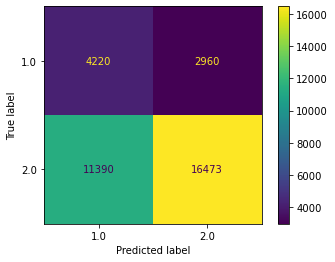

In [58]:
cm = confusion_matrix(y_test, y_pred_rus, labels=clfDT_rus.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clfDT_rus.classes_)
disp.plot()
plt.show()

In [59]:
print("Accuracy:", accuracy_score(y_test, y_pred_rus))
print("Precision:", precision_score(y_test, y_pred_rus))
print("Recall:", recall_score(y_test, y_pred_rus))
print("F1 Score:", f1_score(y_test, y_pred_rus))

Accuracy: 0.590503096196102
Precision: 0.2703395259449071
Recall: 0.5877437325905293
F1 Score: 0.3703378674857394
